<a href="https://colab.research.google.com/github/Datapark1018/LST/blob/main/LST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setting

In [61]:
# 초기 설정
!apt-get -qq install fonts-nanum  # 폰트 설치
from google.colab import drive
drive.mount('/content/drive')
from IPython.display import display
import os

# 데이터 전처리
from datetime import datetime
import pandas as pd
import numpy as np
import random

# 데이터 시각화
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib.dates as mdates
import plotly.express as px
import seaborn as sns

# 데이터 모델링
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.decomposition import PCA


import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Input


# 데이터 프레임 열 전체 보기
pd.set_option('display.max_columns',None)

# 한글 폰트 설정
new_font = fm.FontEntry(fname='/usr/share/fonts/truetype/nanum/NanumGothic.ttf', name='NanumGothic')
fm.fontManager.ttflist.insert(0, new_font)
plt.rc('font', family='NanumGothic')
plt.rcParams['axes.unicode_minus'] = False

# 데이터 feature 설명
columns_dict = {'ta': '평균 기온', 'td' : '이슬점 온도', 'hm' :'습도', 'ws':'평균 풍속', 'rn':'누적 강수량','re':'강수유무 (분)', 'ww':'현천', 'ts':'지표면 온도', 'si':'누적 일사량', 'ss':'누적 일조량', 'sn':'적설'}

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 2. EDA

## Data Overview

1. train 44만여개의 데이터로, 14개의 칼럼 존재
2. target은 지표면 온도인 숫자형 변수 'ts', 나머지 10개의 기상 제원이 주요 feature (1개 범주형 + 9개 숫자형)
3. stn은 관측소 번호, year은 연도 마스킹, mmddhh 관측시간
4. null은 없으나 실질적 결측치인 -99.9 존재

> -99.9로 표기된 결측치외에 다른 방식으로 표기된 결측치 있는지 확인하고 결측치를 보간 또는 제거 必


In [73]:
train = pd.read_csv('drive/MyDrive/Projects/LST/data/train.csv', dtype={"mmddhh":str})
test = pd.read_csv('drive/MyDrive/Projects/LST/data/test.csv', dtype={"mmddhh":str})

display(train.head(3))
print(f"\n{'➖'*50}\n")
display(columns_dict)
print(f"\n{'➖'*50}\n")
display(train.info())
print(f"\n{'➖'*50}\n")
display(train.isnull().sum().to_frame().T)


,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,ts,si,ss,sn
0,1,A,020100,-9.9,-10.7,93.9,0.6,0.0,0,H,-1.3,-99.9,-99.9,-99.9
1,1,A,020101,-10.8,-11.6,93.8,0.6,0.0,0,H,-1.5,-99.9,-99.9,-99.9
2,1,A,020102,-11.4,-12.1,94.6,0.7,0.0,0,H,-1.7,-99.9,-99.9,-99.9



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



{'ta': '평균 기온',
 'td': '이슬점 온도',
 'hm': '습도',
 'ws': '평균 풍속',
 'rn': '누적 강수량',
 're': '강수유무 (분)',
 'ts': '지표면 온도',
 'si': '누적 일사량',
 'ss': '누적 일조량',
 'sn': '적설'}


➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438240 entries, 0 to 438239
Data columns (total 14 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   stn     438240 non-null  int64  
 1   year    438240 non-null  object 
 2   mmddhh  438240 non-null  object 
 3   ta      438240 non-null  float64
 4   td      438240 non-null  float64
 5   hm      438240 non-null  float64
 6   ws      438240 non-null  float64
 7   rn      438240 non-null  float64
 8   re      438240 non-null  int64  
 9   ww      438240 non-null  object 
 10  ts      438240 non-null  float64
 11  si      438240 non-null  float64
 12  ss      438240 non-null  float64
 13  sn      438240 non-null  float64
dtypes: float64(9), int64(2), object(3)
memory usage: 46.8+ MB


None


➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,ts,si,ss,sn
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Preprocessing

**Details about 'ww'**
> C : 맑음 | H : 박무 | R : 비 | G : 연무 | X : 모름 | F : 안개 | S : 눈

**'ts'는 target이고 'ta'는 평균 기온으로 관련 지수가 높으므로** 결측치가 있는 행 모두 제거

시간적 흐름을 살펴보기 위해서 'date' 칼럼 생성

**'ww'**칼럼의 경우 날씨를 뜻하고 다른 feature의 특성과 관련 있으므로 제거
- '습도'와 '일사량' 등 다른 요소로 설명 가능
- 차원 늘어남에 따라 모델 복잡도 증가

In [63]:
display(train.min().to_frame().T)
display(train['ww'].value_counts().to_frame().T)

# 날짜 데이터 생성
train['date'] = pd.to_datetime([str(2017 + ord(x) - ord("A")) for x in train['year']] + train['mmddhh'], format="%Y%m%d%H")
train = train.sort_values(['stn', 'date'])

# 'ww' 제거
train = train.drop(columns=['ww'])
del columns_dict['ww']

,stn,year,mmddhh,ta,td,hm,ws,rn,re,ww,ts,si,ss,sn
0,1,A,010100,-99.9,-99.9,-99.9,-99.9,-99.9,-99,C,-99.9,-99.9,-99.9,-99.9


ww,C,H,R,G,X,F,S
count,290265,58793,49177,30100,3514,3499,2892


## Missing Value

- 시간적 특성과 관련된 si, ss / 계절적 특성과 관련된 sn에서 높은 비율의 결측치 발견
- 이는 관측장비의 오작동 혹은 부재로 인한 결측치 아님을 판단
- 이에 결측치 = 해당 특성 요소 없음(0) 으로 판단


In [64]:
# 결측치(-99.9) 확인
for x in columns_dict.keys():
  print(f"{x} {columns_dict[x]}:  {round(train[train[x]<=-99].shape[0]*100 / train.shape[0],2)} %")

print(f"\n=> ts 및 ta 결측치 {train[(train['ts'] == -99.9) | (train['ta'] == -99.9)].shape[0]} 개 행 제거\n")
train = train[(train['ts'] != -99.9) & (train['ta'] != -99.9)]

# 결측치(-99.9) 처리
for col in columns_dict.keys():
  if col in ['si', 'ss', 'sn']:
    train.loc[train[col] <= -99, col] = 0
  else:
    train.loc[train[col] <= -99, col] = None
    train.loc[:, col] = train[col].interpolate()

ta 평균 기온:  0.14 %
td 이슬점 온도:  0.15 %
hm 습도:  0.13 %
ws 평균 풍속:  0.23 %
rn 누적 강수량:  1.69 %
re 강수유무 (분):  0.49 %
ts 지표면 온도:  0.14 %
si 누적 일사량:  45.64 %
ss 누적 일조량:  45.42 %
sn 적설:  98.36 %

=> ts 및 ta 결측치 690 개 행 제거



## Graphs



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖




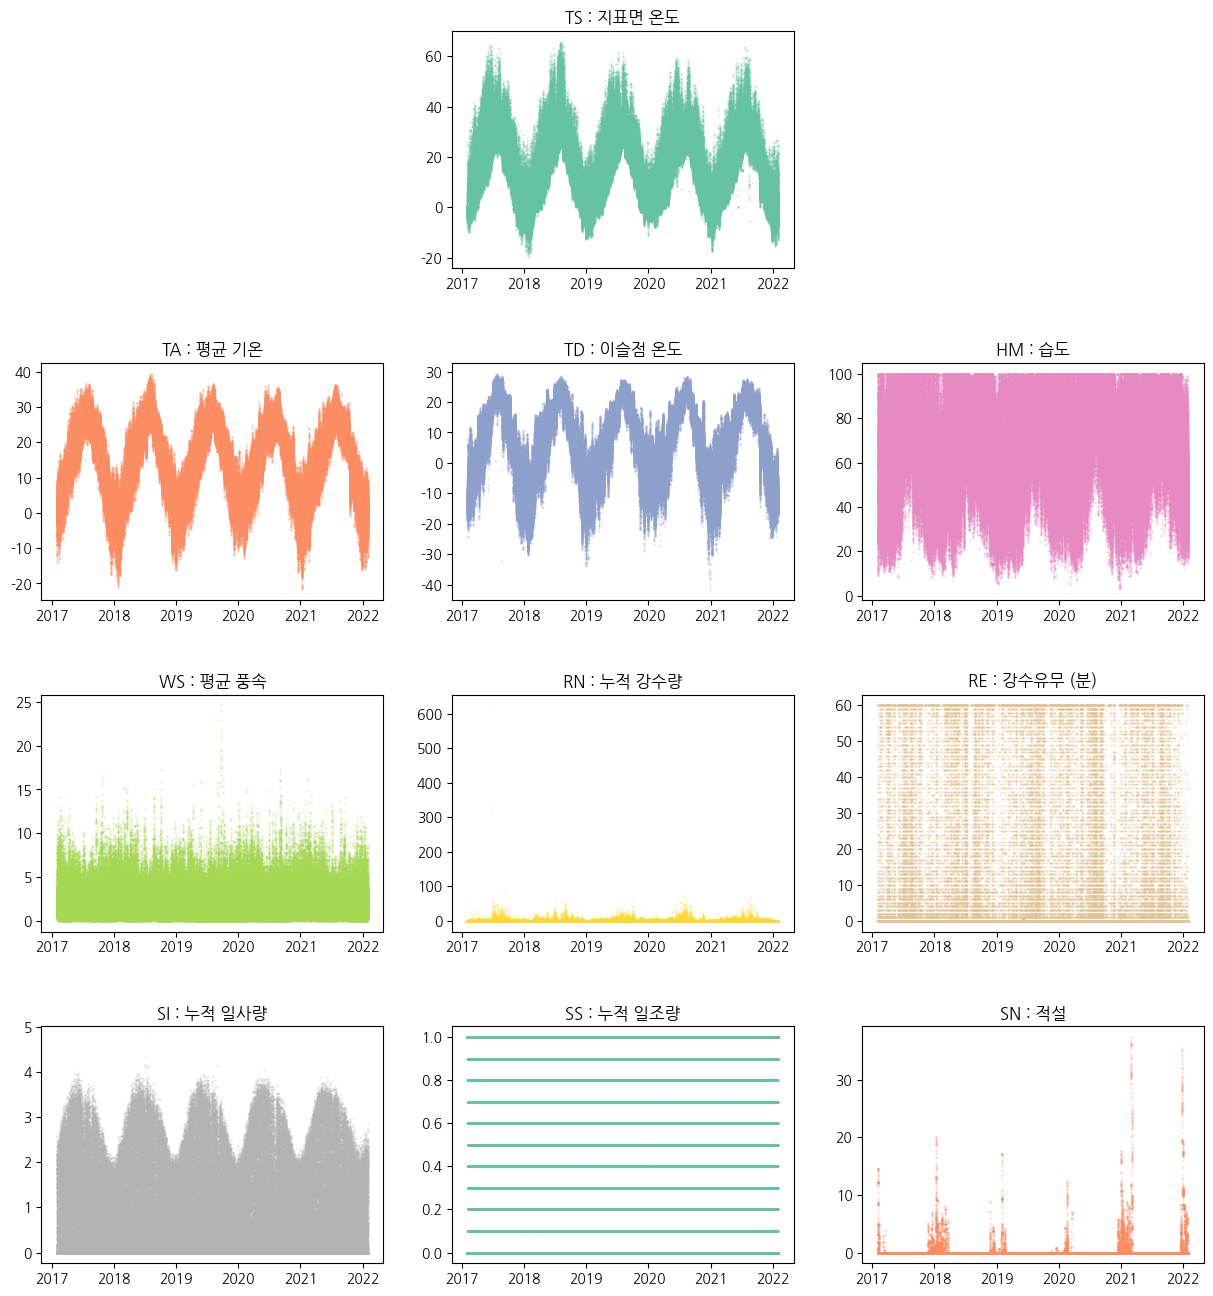



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖




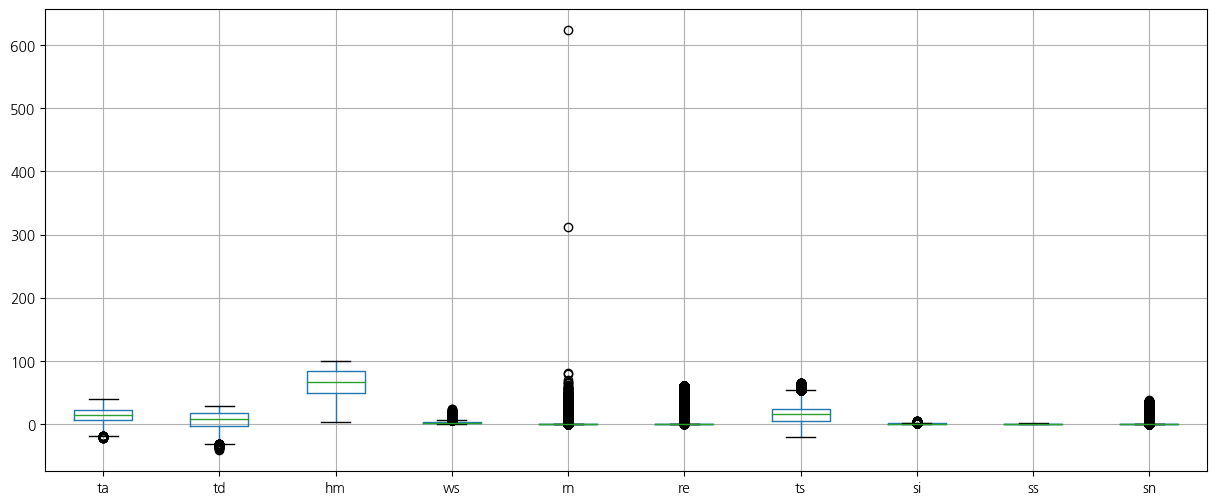



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖




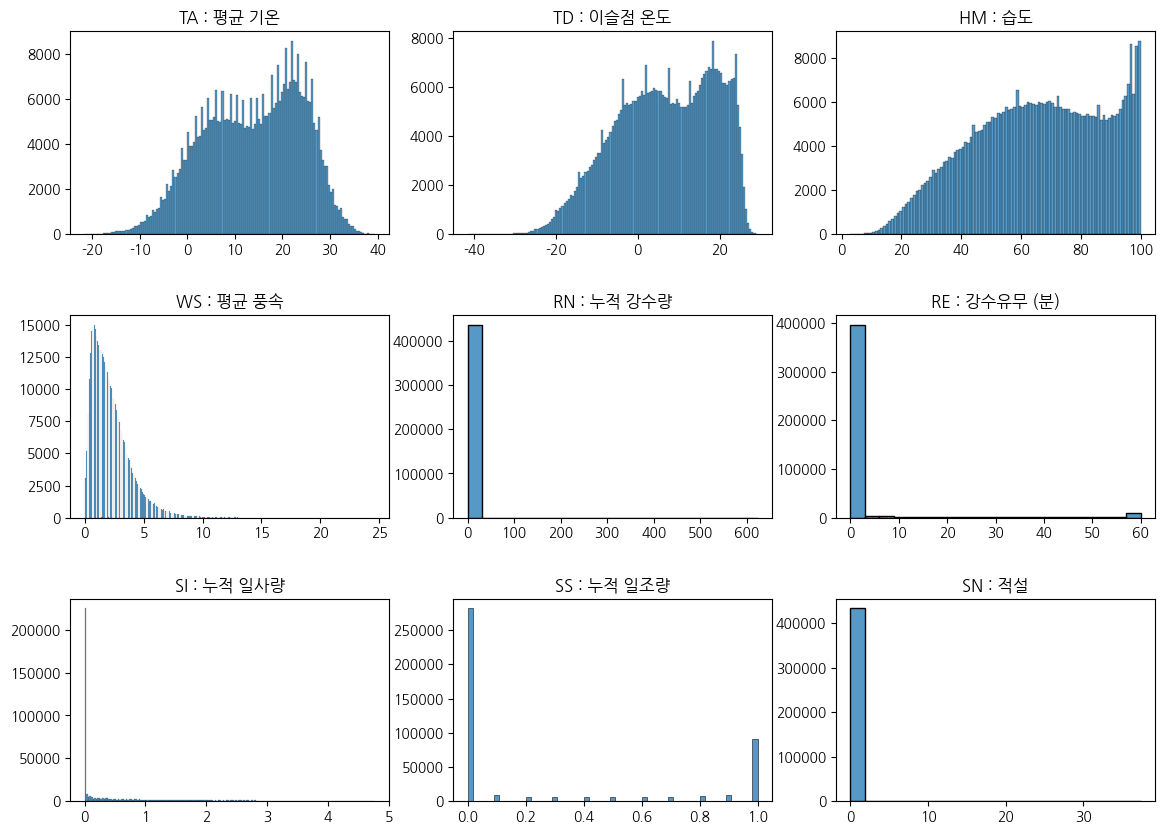



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖




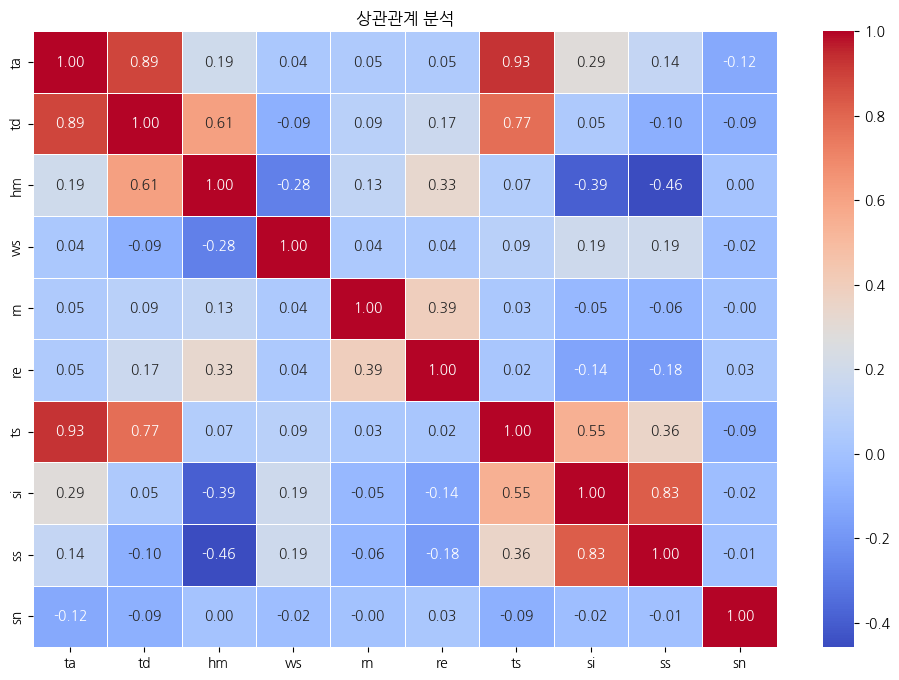

In [ ]:
print(f"\n\n{'➖'*50}\n\n")
fig, axes = plt.subplots(4, 3, figsize=(15, 16))

train.plot.scatter(x='date', y='ts', s=0.3, alpha=0.3, color=sns.color_palette("Set2", 10)[0], ax=axes[0,1])
axes[0, 1].set_xlabel(""), axes[0, 1].set_ylabel(""), axes[0, 1].set_title(f"{'ts'.upper()} : {columns_dict['ts']}", fontweight='bold')
axes[0,0].axis('off'), axes[0,2].axis('off')

for idx, col in enumerate([x for x in columns_dict.keys() if x not in ['ts']]):
  row_idx, col_idx = (idx//3) + 1, idx%3
  train.plot.scatter(x='date', y=col, s=0.3, alpha=0.3, color=sns.color_palette("Set2", 10)[idx+1], ax=axes[row_idx, col_idx])
  axes[row_idx, col_idx].set_xlabel(""), axes[row_idx, col_idx].set_ylabel(""), axes[row_idx, col_idx].set_title(f"{col.upper()} : {columns_dict[col]}", fontweight='bold')
plt.subplots_adjust(hspace=0.4)
plt.show()

print(f"\n\n{'➖'*50}\n\n")
train[columns_dict.keys()].boxplot(figsize=(15,6))
plt.show()


print(f"\n\n{'➖'*50}\n\n")
plt.figure(figsize=(14,10))

for idx, col in enumerate([x for x in columns_dict.keys() if x not in ['ts']]):
  plt.subplot(3,3,idx+1,title=col)
  sns.histplot(train[col])
  plt.xlabel(""), plt.ylabel(""), plt.title(f"{col.upper()} : {columns_dict[col]}")
plt.subplots_adjust(hspace=0.4)
plt.show()


print(f"\n\n{'➖'*50}\n\n")
plt.figure(figsize=(12, 8))

corr_matrix = train[columns_dict.keys()].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('상관관계 분석')
plt.show()

# Modeling

## Non-scaling

경사하강법 우수

- Linear Regression	: 8.343995 / 0.947737
- Random Forest Regressor : 6.843833 / 0.957133
- Gradient Boosting Regressor : 6.689077 / 0.958103
- Decision Tree Regressor : 12.906309 / 0.919161

In [ ]:
X = train[columns_dict.keys()].drop(columns=['ts'])
y = train['ts']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor()
}

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results.append([name, mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)])

results_df = pd.DataFrame(data=results, columns=['name','MSE', "R²"]).sort_values("R²", ascending=False).set_index('name')
display(results_df)


,name,MSE,R²
0,Linear Regression,8.343995,0.947737
1,Random Forest Regressor,6.843833,0.957133
2,Gradient Boosting Regressor,6.689077,0.958103
3,Decision Tree Regressor,12.906309,0.919161


## Scaling

- Linear Regression	8.343995	0.947737
-	Random Forest Regressor	6.828335	0.957230
-	Gradient Boosting Regressor	6.689079	0.958103
-	Decision Tree Regressor	12.948694	0.918895
-	KNeighbors Regressor	7.508699	0.952969
-	MLP Regressor (Neural Network)	6.416900	0.959808
-	LSTM	6.483621	0.959390

In [ ]:
X = train[columns_dict.keys()].drop(columns=['ts'])
y = train['ts']

# scaling
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "MLP Regressor (Neural Network)": MLPRegressor()
}

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results.append([name, mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)])

# LSTM 모델
def build_lstm_model(input_shape):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = build_lstm_model((X_train.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm)

results.append(['LSTM', mean_squared_error(y_test, y_pred_lstm), r2_score(y_test, y_pred_lstm)])

results_df = pd.DataFrame(data=results, columns=['name','MSE', "R²"]).sort_values("R²", ascending=False).set_index('name')
display(results_df)

2735/2735 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


,name,MSE,R²
0,Linear Regression,8.343995,0.947737
1,Random Forest Regressor,6.828335,0.957230
2,Gradient Boosting Regressor,6.689079,0.958103
3,Decision Tree Regressor,12.948694,0.918895
4,KNeighbors Regressor,7.508699,0.952969
5,MLP Regressor (Neural Network),6.416900,0.959808
6,LSTM,6.483621,0.959390


In [14]:
X = train[columns_dict.keys()].drop(columns=['ts'])
y = train['ts']

# scaling
X = StandardScaler().fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []

# LSTM 모델
def build_lstm_model(input_shape):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = build_lstm_model((X_train.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm)

results.append(['LSTM', mean_squared_error(y_test, y_pred_lstm), r2_score(y_test, y_pred_lstm)])

results_df = pd.DataFrame(data=results, columns=['name','MSE', "R²"]).sort_values("R²", ascending=False).set_index('name')
display(results_df)

2735/2735 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step


,MSE,R²
name,,
LSTM,6.473219,0.959455


## Scaling + PCA

7개에서 기울기가 완만해지고 설명력도 충분하여 차원은 7개로 축소

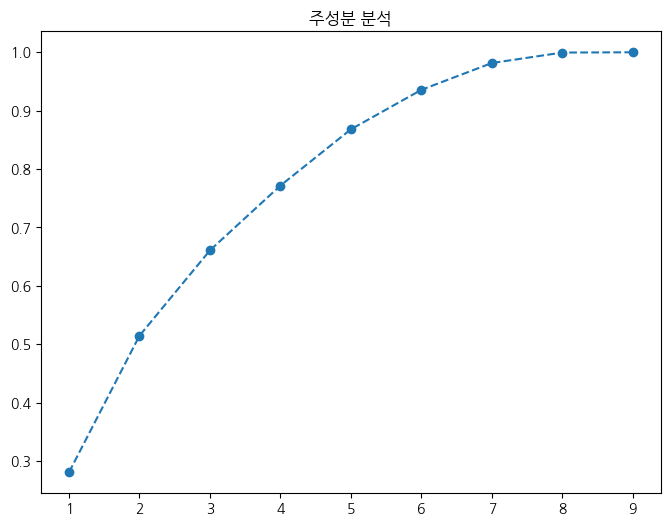

1 차원 설명력 : 0.28086615372773194
2 차원 설명력 : 0.5146920159377616
3 차원 설명력 : 0.6608290867751765
4 차원 설명력 : 0.7717028499376376
5 차원 설명력 : 0.8680418351866371
6 차원 설명력 : 0.9356510931112287
7 차원 설명력 : 0.9815408393333436
8 차원 설명력 : 0.9995067324297694
9 차원 설명력 : 1.0000000000000002


In [ ]:
X = train[columns_dict.keys()].drop(columns=['ts'])
y = train['ts']

# scaling
X = StandardScaler().fit_transform(X)

# PCA
def PCA_plot():
  pca = PCA()
  pca.fit(X)

  explained_variance_ratio = pca.explained_variance_ratio_
  cumulative_variance = np.cumsum(explained_variance_ratio)

  plt.figure(figsize=(8, 6))
  plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o', linestyle='--')
  plt.title('주성분 분석')
  plt.show()

  [print(f"{idx+1} 차원 설명력 : {variance}") for idx, variance in enumerate(cumulative_variance)]

PCA_plot()

X = PCA(n_components=7).fit_transform(X)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

results = []
models = {
    "Linear Regression": LinearRegression(),
    "Random Forest Regressor": RandomForestRegressor(),
    "Gradient Boosting Regressor": GradientBoostingRegressor(),
    "Decision Tree Regressor": DecisionTreeRegressor(),
    "KNeighbors Regressor": KNeighborsRegressor(),
    "MLP Regressor (Neural Network)": MLPRegressor()
}

for name, model in models.items():
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)
  results.append([name, mean_squared_error(y_test, y_pred), r2_score(y_test, y_pred)])

# LSTM 모델
def build_lstm_model(input_shape):
  model = Sequential()
  model.add(Input(shape=input_shape))
  model.add(LSTM(64, return_sequences=True))
  model.add(LSTM(64, return_sequences=False))
  model.add(Dense(1))
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

lstm_model = build_lstm_model((X_train.shape[1], 1))
lstm_model.fit(X_train_lstm, y_train, epochs=10, batch_size=32, verbose=0)
y_pred_lstm = lstm_model.predict(X_test_lstm)

results.append(['LSTM', mean_squared_error(y_test, y_pred_lstm), r2_score(y_test, y_pred_lstm)])

results_df = pd.DataFrame(data=results, columns=['name','MSE', "R²"]).sort_values("R²", ascending=False).set_index('name')
display(results_df)

2735/2735 ━━━━━━━━━━━━━━━━━━━━ 12s 4ms/step


,name,MSE,R²
0,Linear Regression,10.075153,0.936894
1,Random Forest Regressor,7.329695,0.954090
2,Gradient Boosting Regressor,7.648836,0.952091
3,Decision Tree Regressor,14.134219,0.911470
4,KNeighbors Regressor,8.109126,0.949208
5,MLP Regressor (Neural Network),6.629592,0.958475
6,LSTM,6.966428,0.956366


## Residual plot

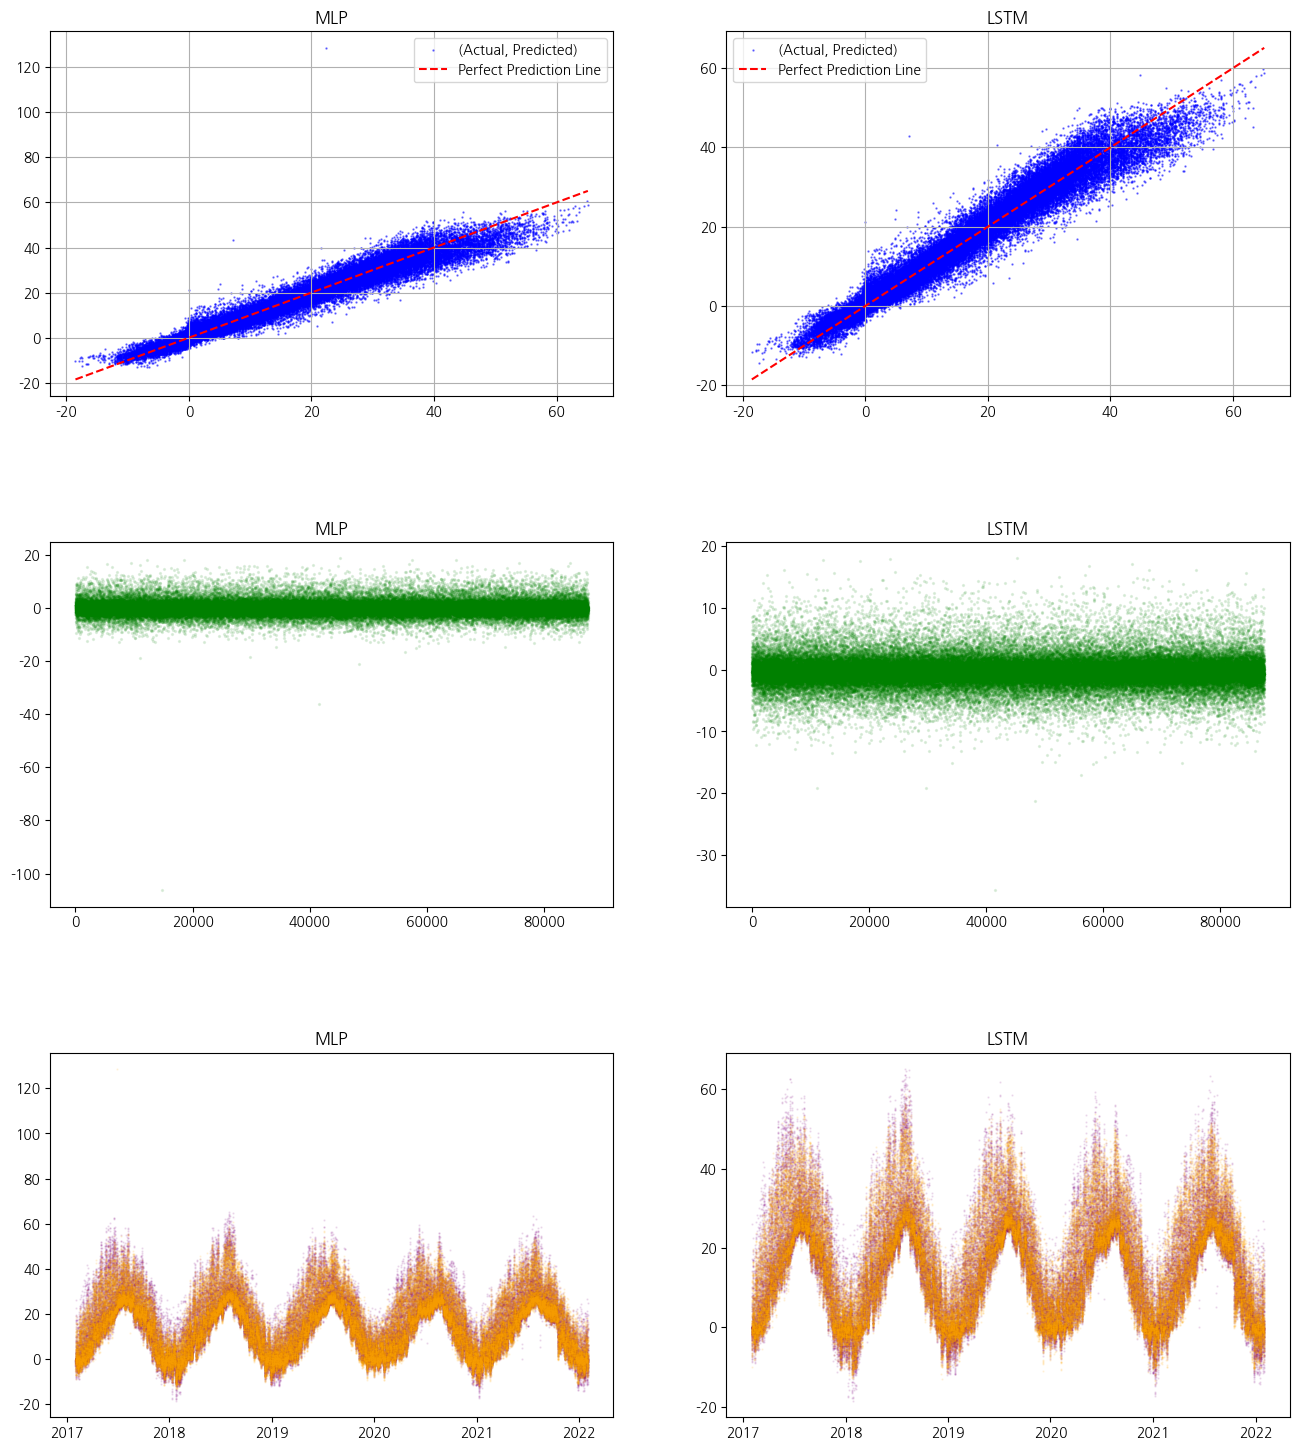


➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



,Absolute Error
47357,106.232292
117732,36.071405
125854,20.966327
39720,18.878939
396613,18.595227



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



,Absolute Error
117732,35.700360
125854,21.281807
213420,19.220833
39720,19.174204
396613,18.034241



➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖➖



,Absolute Error
47357,1.000329


In [71]:
df = pd.DataFrame({'Actual': y_test, 'MLP': y_pred, "LSTM": y_pred_lstm.ravel()})
df = df.join(train[['date']])

plt.figure(figsize=(16,18))
graph_num = 0

for idx, col in enumerate(["MLP", "LSTM"]):
  graph_num += 1
  plt.subplot(3,2, graph_num, title=col)
  plt.scatter(data=df, x="Actual", y=col, color='blue', alpha=0.5, s=0.5, label="(Actual, Predicted)")
  plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction Line')
  plt.legend(), plt.grid(True)


for idx, col in enumerate(["MLP", "LSTM"]):
  graph_num += 1
  plt.subplot(3,2,graph_num, title=col)
  plt.scatter(range(len(df)), df['Actual'] - df[col], s=2, color='Green',alpha=0.1)
  plt.title(col)


for idx, col in enumerate(["MLP", "LSTM"]):
  graph_num += 1
  plt.subplot(3,2,graph_num, title=col)
  plt.scatter(data=df, x='date', y='Actual', alpha=0.1, s=0.5, color='purple')
  plt.scatter(data=df, x='date', y=col, alpha=0.1, s=0.5, color='orange')
  plt.title(col)

plt.subplots_adjust(hspace=0.4)
plt.show()

print(f"\n{'➖'*50}\n")
display(pd.DataFrame((y_test-y_pred).abs()).sort_values('ts', ascending=False).rename(columns={"ts":"Absolute Error"}).head(5))

print(f"\n{'➖'*50}\n")
display(pd.DataFrame((y_test-y_pred_lstm.ravel()).abs()).sort_values('ts', ascending=False).rename(columns={"ts":"Absolute Error"}).head(5))

print(f"\n{'➖'*50}\n")
display(pd.DataFrame((y_test-y_pred_lstm.ravel()).abs()).sort_values('ts', ascending=False).rename(columns={"ts":"Absolute Error"}).loc[47357].to_frame().T)

## Conclusion

- Non/Scaling과 PCA를 비교해본 결과 feature의 개수가 많지 않은 덕에 단순 scaling을 진행한 경우 가장 모델의 성능이 좋았음

- 전반적으로 평균 오차가 작고 설명력이 좋은 모델은 아래와 같다.
  - 1. LSTM
  - 2. MLP
  - 3. Gradient Boosting
  - 4. Random Forest
  > 의사결정트리 모형과 신경망 모델이 성능이 좋은 것으로 판단됨

- 단, MLP 모델의 경우 이상치에 민감한 반응을 하여 실제 기상 정확도를 위해서는 사용에 부적합 판단.

- 시간적 특성에 영향을 많이 받는 데이터 특성상, LSTM 모델이 오차와 설명력을 기준으로 했을때 가장 적합한 모델로 판단